
<image src="https://raw.githubusercontent.com/ramiro999/depth-passive-sesion4/main/images/portada.png" width=100%>


# <center> **04. Estimación pasiva de la profundidad** </center>

La estimación pasiva de la profundidad es el conjunto de técnicas y algoritmos para estimar la distancia observada de objetos para permitir una comprensión tridimensional (3D) del entorno circundante. Durante esta sesión vamos a aplicar los conceptos explicados, **para estimar la disparidad en imágenes estéreo prediseñadas mediante diversas técnicas de programación y así obtener los mapas de disparidad y profundidad.**

## **Contenido**

[**1. Introducción a la visión estéreo**](#tema1)

[**2. Profundidad y Disparidad**](#tema2)

[**3. Trangulacion, Correspondencia y Geometría epipolar**](#tema3)

In [3]:
#@title **Cargar librerias**
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import cv2 as cv

In [4]:
#@title **Montar drive**
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
#@title **Moverse a la carpeta donde guardaron el noteboook**
%cd "/content/drive/MyDrive/depth-passive-sesion4"

/content/drive/MyDrive/depth-passive-sesion4


## <font color='#4C5FDA'>**1. Introducción a la visión estéreo**</font> <a name="tema1">




<font color="EB9A54"> **Visión estéreo** </font> es la técnica de estimación pasiva de la profundidad que se basa en la extracción de información 3D por computación (profundidad, forma, tamaño y ubicación de objetos en el espacio) proveniente de imagenes digitales de multiples escenas, como las obtenidas por una camara CCD. Este enfoque se utiliza en múltiples aplicaciones, como sistemas de asistencia al conductor, navegación robótica, mapeo de escenas, inferencia de profundidad para entretenimiento y, en general, cualquier aplicación donde la profundidad de los objetos en la escena sea una información valiosa.

<div align="center"> <image src="https://raw.githubusercontent.com/ramiro999/depth-passive-sesion4/main/images/vision-stereo-1.png" width=600>  </div>








<font color="EB9A54">**Sistema de visión estéreo estandar**</font>

Al tener múltiples imágenes de una escena, es posible crear un mapa 3D de esa escena utilizando técnicas de visión estéreo. Esto no requiere dos cámaras, sino dos vistas diferentes de la escena. En este sentido, tenemos diferentes posibilidades:

- Dos camaras.
- Imágenes tomadas simultáneamente.
- Se conoce la pose relativa de las cámaras.

<div align="center"> <image src="https://raw.githubusercontent.com/ramiro999/depth-passive-sesion4/main/images/sistema_estereovision.png" width=600>  </div>



<font color="EB9A54">**Reconstrucción de escena usando visión estéreo**</font>

Al tener dos cámaras separadas, podemos reconstruir una escena **(obtener un mapa 3D a tamaño real)** conociendo la disparidad de cada punto y los parámetros intrínsecos de la cámara:

<div align="center"> <image src="https://raw.githubusercontent.com/ramiro999/depth-passive-sesion4/main/images/stereo-reconstruction.png" width=600>  </div>

En este caso particular, se siguió un enfoque estéreo denso en el que se calculó la profundidad para cada píxel de las imágenes para lograr la reconstrucción 3D de la mayor parte de la escena.

Ahora sabemos que el objetivo de la visión estéreo es recuperar información 3D a partir de imágenes 2D. Un objetivo ambicioso, ¿no?


<font color="EB9A54">**Modelo de visión estéreo**</font>

Conoce el siguiente modelo que describe de los pasos claves de visión estéreo.

<div align="center"> <image src="https://raw.githubusercontent.com/ramiro999/depth-passive-sesion4/main/images/metodologia.png" width=800>  </div>


- <font color= "52F17F"> **Calibración:**  </font> La calibración de la cámara se refiere tanto a la intrínseca como a la extrínseca. La calibración intrínseca determina el centro de la imagen, la distancia focal y los parámetros de distorsión, mientras que la calibración extrínseca determina las posiciones 3D de las cámaras. Este es un paso crucial en muchas aplicaciones de visión artificial, sobre todo cuando se requiere información métrica de la escena, como la profundidad.

- <font color="52F17F"> **Rectificación:** </font> La rectificación estéreo se refiere al proceso de reproyección de los planos de la imagen en un plano común paralelo a la línea entre los centros de las cámaras. Tras la rectificación, los puntos correspondientes se encuentran en la misma fila, lo que reduce en gran medida el coste y la ambigüedad del emparejamiento.

- <font color="52F17F"> **Emparejamiento estéreo:** </font> Se refiere al proceso de emparejamiento de píxeles entre las imágenes izquierda y derecha, que genera imágenes de disparidad. El algoritmo de coincidencia semiglobal (SGM) es uno de los más utilizados.

- <font color="52f17f"> **Triangulación:**</font> La triangulación se refiere al proceso de determinar un punto en el espacio 3D dada su proyección en las dos imágenes. La imagen de disparidad se convertirá en una nube de puntos 3D.

<font color="EB9A54"> **Prueba 1:** </font> En un caso ideal, se capturan imágenes estéreo que han sido calibradas y rectificadas.

- Carga las imagenes del dataset `motorcycle` disponible en la carpeta de datos.
- Visualiza las imagenes
- ¿Ambas imagenes son diferentes o iguales?


(2000, 2964)

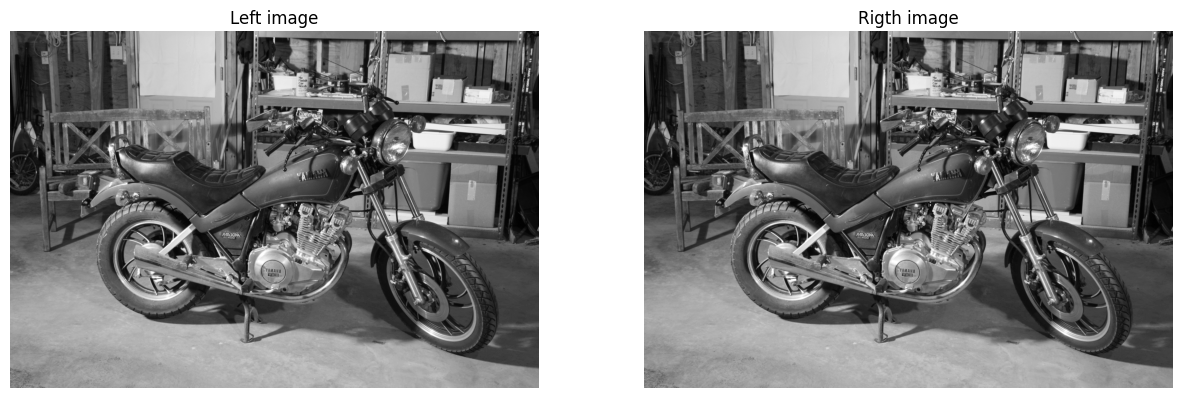

In [20]:
# Carga las imagenes en escala de grises

"""Pon tu código aquí"""
imgL = "/content/drive/MyDrive/depth-passive-sesion4/datasets/motorcycle/imL.png"
imgR = "/content/drive/MyDrive/depth-passive-sesion4/datasets/motorcycle/imL.png"

left_image_path = cv.imread(imgL, cv.IMREAD_GRAYSCALE)
rigth_image_path = cv.imread(imgR, cv.IMREAD_GRAYSCALE)

# Visualiza ambas imagenes

"""Pon tu código aquí"""

plt.figure(figsize=(15,9))
plt.subplot(1, 2, 1)
plt.imshow(left_image_path, cmap= 'gray')
plt.title('Left image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(rigth_image_path, cmap= 'gray')
plt.title('Rigth image')
plt.axis('off')



## <font color='#4C5FDA'>**2. Disparidad y Profundidad**</font> <a name="tema2">


Hasta el momento hemos hablado de disparidad y profundidad, pero <font color= "52F17F" >**¿Queda claro el significado de ambos terminos?**</font>

✅ Veamoslo:

<font color = "EB9A54"> **Disparidad** </font>

En los seres humanos, la percepción visual de la estructura tridimensional es realizada por el sistema visual humano, mediante los ojos y el cerebro. Dada la posición
de los ojos, las imágenes que éstos presentan al cerebro son prácticamente idénticas salvo por una cierta diferencia en la posición relativa de los objetos en dichas imágenes.
A esta diferencia relativa se le denomina disparidad, y tiene una relación directa con la distancia (profundidad) a la que se encuentran los objetos entre sí y respecto del
observador. El cerebro es capaz de interpretar esa diferencia y reconstruir la estructura tridimensional de la escena que se está observando. El problema de la correspondencia estéreo trata por tanto de dar solución a ese mismo rompecabezas que el cerebro resuelve automáticamente de forma tan aparentemente sencilla.

En resumen, **la** disparidad es una medida fundamental en la visión estéreo que permite la percepción de profundidad. En otras palabras, se refiere a la diferencia en la posición horizontal de pixeles correspondientes a la imagenes izquierda y derecha.

$$ \color{orange} {d = X_l - X_d} $$

donde $\mathbf{d}$ es la disparidad, $\mathbf{X_l}$ es la posición horizontal de puntos en la camara izquierda y $\mathbf{X_d}$ es la posición horizontal de puntos en la cámara derecha.

Los algoritmos destinados a obtener el mapa de disparidad de una imagen, se
denominan algoritmos de correspondencia estéreo, y pueden ser clasificados,
fundamentalmente, en dos grandes grupos:
- Basados en área
- Basados en características

<font color = "EB9A54"> **Profundidad** </font>

Se entiende por profundidad a la distancia a la que se encuentran los objetos entre sí y respecto de las camaras.

$$\color{orange}  {Z = \frac{fB}{d}} $$

donde $\mathbf{Z}$ es la profundidad, $\mathbf{f}$ es la distancia focal, $\mathbf{B}$ es la linea de base, y $\mathbf{d}$ es la disparidad.


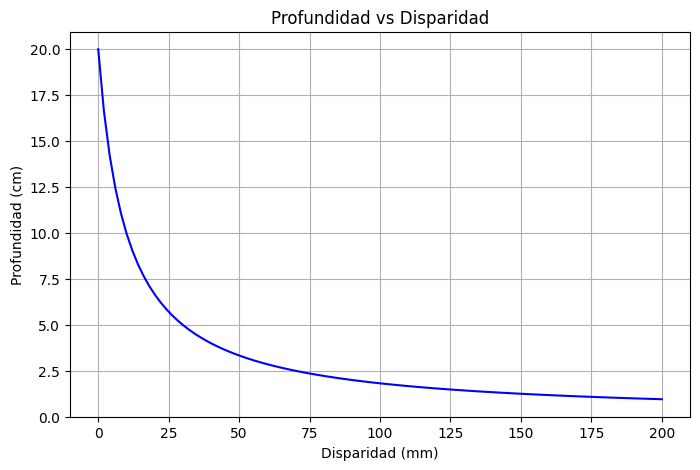

In [25]:
#@title Por ende la profundidad es inversamente proporcional a la disparidad

disparidad = np.linspace(0, 200, 100) # Disparidad de 0 a 200
profundidad = 1 / (0.005 * disparidad + 0.05) # Relacion inversamente proporcional

# Plotting the data
plt.figure(figsize=(8, 5))
plt.plot(disparidad, profundidad, label='Profundidad Real', color='blue')
plt.title('Profundidad vs Disparidad')
plt.xlabel('Disparidad (mm)')
plt.ylabel('Profundidad (cm)')
plt.grid(True)
plt.show()

<font color="EB9A54"> **Prueba 2:** </font> Aplicación de la visión estéreo y cálculo del mapa de disparidad

- Carga las imagenes del dataset `tsukuba` disponible en la carpeta de datos.
- Utiliza la función `cv.StereoBM_create` para crear un objeto de coincidencia de bloques stereo.
- Calcula el mapa de disparidad para las imagenes con la función `compute`
- Utiliza una metrica de valor medio para calcular la disparidad del mapa.
- Visualiza las imagenes y el mapa de disparidad

In [ ]:
# Carga las imagenes en escala de grises.

"""Pon tu código aquí"""

# Aplica la función cv.StereoBM_create.

"""Pon tu código aquí"""

# Aplica la función compute.

"""Pon tu código aquí"""

# Metrica de valor medio.

"""Pon tu código aquí"""

# Visualiza las imagenes y el mapa de disparidad

"""Pon tu código aquí"""

# 2. Implementación (Borrar)

[[-16 -16 -16 ... -16 -16 -16]
 [-16 -16 -16 ... -16 -16 -16]
 [-16 -16 -16 ... -16 -16 -16]
 ...
 [-16 -16 -16 ... -16 -16 -16]
 [-16 -16 -16 ... -16 -16 -16]
 [-16 -16 -16 ... -16 -16 -16]]


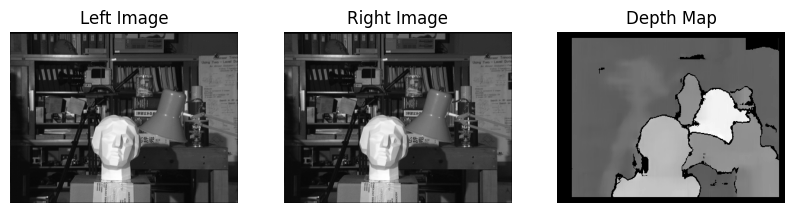

In [ ]:
#@title Implementación sencilla

import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

# Cargar las imagenes
left_image_path = '/content/drive/MyDrive/Pregrado-UIS/SEMESTRE-IX-2024-1/Hands-on/Notebook/images/tsukuba/imL.png'
right_image_path = '/content/drive/MyDrive/Pregrado-UIS/SEMESTRE-IX-2024-1/Hands-on/Notebook/images/tsukuba/imR.png'
left_image = cv.imread(left_image_path, cv.IMREAD_GRAYSCALE)
right_image = cv.imread(right_image_path, cv.IMREAD_GRAYSCALE)


# Crear el objeto StereoBM y calcular el mapa de profundidad
stereo = cv.StereoBM_create(numDisparities=16, blockSize=15) # Por que 16? Porque solo el numDisparities y blockSize?
depth = stereo.compute(left_image, right_image)

print(depth)

# Display left image
plt.figure(figsize=(10, 7))
plt.subplot(1, 3, 1)
plt.imshow(left_image, cmap='gray')
plt.title('Left Image')
plt.axis('off')

# Display right image
plt.subplot(1, 3, 2)
plt.imshow(right_image, cmap='gray')
plt.title('Right Image')
plt.axis('off')

# Display depth map
plt.subplot(1, 3, 3)
plt.imshow(depth, cmap='gray')
plt.title('Disparity Map')
plt.axis('off')

plt.show()

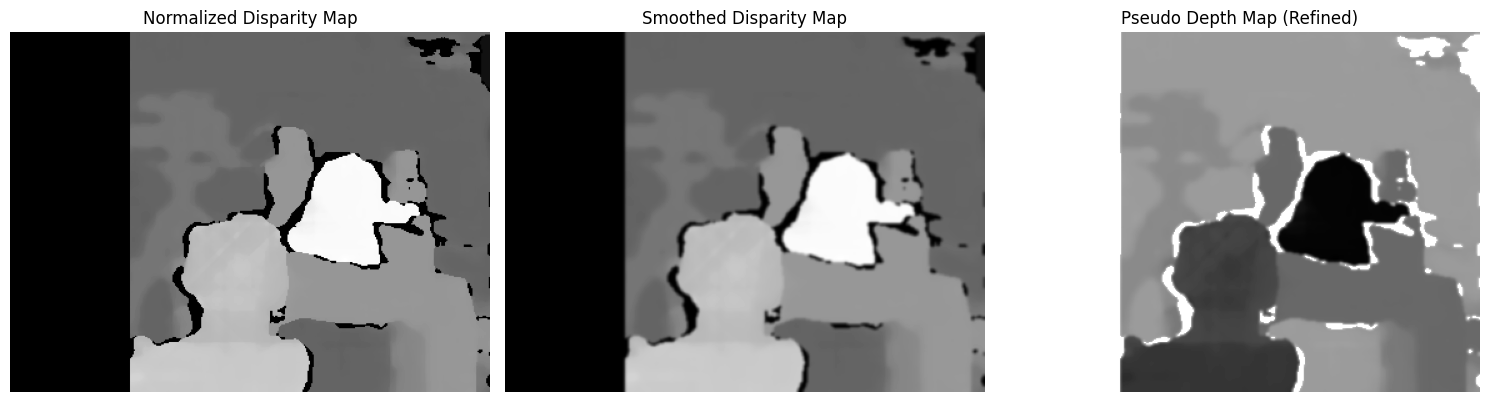

In [ ]:
#@title Más parametros

import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow

# Cargar las imágenes
left_image_path = '/content/drive/MyDrive/Pregrado-UIS/SEMESTRE-IX-2024-1/Hands-on/Notebook/images/tsukuba/imL.png'
right_image_path = '/content/drive/MyDrive/Pregrado-UIS/SEMESTRE-IX-2024-1/Hands-on/Notebook/images/tsukuba/imR.png'
left_image = cv.imread(left_image_path, cv.IMREAD_GRAYSCALE)
right_image = cv.imread(right_image_path, cv.IMREAD_GRAYSCALE)

# Preprocesamiento con un filtro Gaussiano (opcional)
# left_image = cv.GaussianBlur(left_image, (5, 5), 0)
# right_image = cv.GaussianBlur(right_image, (5, 5), 0)

# Crear el objeto StereoSGBM y calcular el mapa de profundidad
min_disparity = 0
num_disparities = 6*16
block_size = 11
P1 = 8 * 3 * block_size ** 2
P2 = 32 * 3 * block_size ** 2
disp12_max_diff = 1
pre_filter_cap = 63
uniqueness_ratio = 15
speckle_window_size = 100
speckle_range = 2

# Initialize the stereo matching algorithm with the parameters
stereo_sgbm = cv.StereoSGBM_create(
    minDisparity=min_disparity,
    numDisparities=num_disparities,
    blockSize=block_size,
    P1=P1,
    P2=P2,
    disp12MaxDiff=disp12_max_diff,
    preFilterCap=pre_filter_cap,
    uniquenessRatio=uniqueness_ratio,
    speckleWindowSize=speckle_window_size,
    speckleRange=speckle_range
)

# Preprocessing the images
imgL_new_eq = cv.equalizeHist(left_image)
imgR_new_eq = cv.equalizeHist(right_image)

# Compute disparity map
disparity_sgbm = stereo_sgbm.compute(imgL_new_eq, imgR_new_eq)

# Normalize the disparity map
disparity_sgbm_normalized = cv.normalize(disparity_sgbm, None, alpha=0, beta=255, norm_type=cv.NORM_MINMAX)

# Apply a Gaussian blur to smooth the disparity map
disparity_sgbm_smoothed = cv.GaussianBlur(disparity_sgbm_normalized, (5, 5), 0)

# Convert to 8-bit image
disparity_sgbm_smoothed = np.uint8(disparity_sgbm_smoothed)

# Threshold the disparity map to enhance the effect of closer objects and to suppress noise
_, disparity_sgbm_thresh = cv.threshold(disparity_sgbm_smoothed, 0, 255, cv.THRESH_TOZERO + cv.THRESH_OTSU)

# Invert the disparity map to create a pseudo-depth map
pseudo_depth_map_sgbm = 255 - disparity_sgbm_thresh

# Show the final results
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(disparity_sgbm_normalized, cmap='gray')
axes[0].set_title('Normalized Disparity Map')
axes[0].axis('off')

axes[1].imshow(disparity_sgbm_smoothed, cmap='gray')
axes[1].set_title('Smoothed Disparity Map')
axes[1].axis('off')

axes[2].imshow(pseudo_depth_map_sgbm, cmap='gray')
axes[2].set_title('Pseudo Depth Map (Refined)')
axes[2].axis('off')

plt.tight_layout()
plt.show()


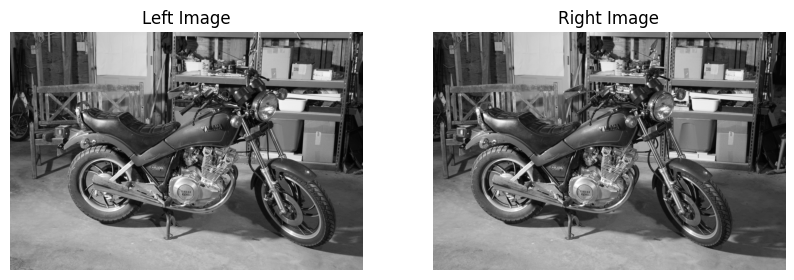

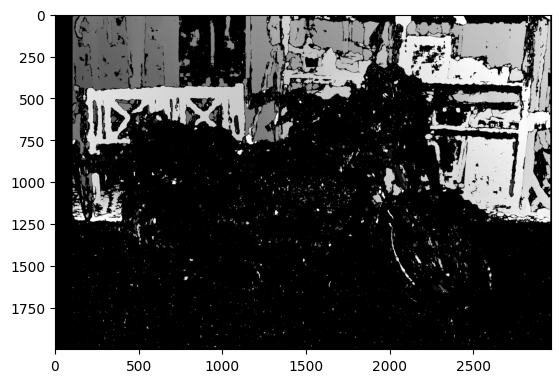

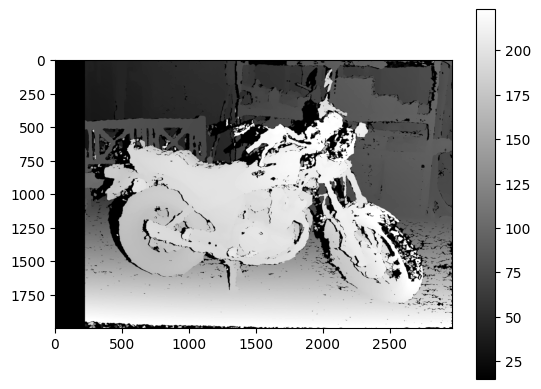

In [ ]:
#@title Implementación sencilla 2

import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

class DepthMap:
  def __init__(self, showImages):
    # Definimos la ruta de las imagenes
    root = '/content/drive/MyDrive/Pregrado-UIS/SEMESTRE-IX-2024-1/Hands-on/Notebook/images/motorcycle'
    imgLeftPath = os.path.join(root, 'imL.png')
    imgRightPath = os.path.join(root, 'imR.png')
    self.imgLeft = cv.imread(imgLeftPath, cv.IMREAD_GRAYSCALE)
    self.imgRight = cv.imread(imgRightPath, cv.IMREAD_GRAYSCALE)



    if showImages:
      plt.figure(figsize=(10, 5))  # Ajusta el tamaño de la figura para mejor visualización
      plt.subplot(1, 2, 1)  # Corrige esta línea para mostrar la imagen izquierda correctamente
      plt.imshow(self.imgLeft, cmap='gray')
      plt.title('Left Image')
      plt.axis('off')  # Opcional: elimina los ejes para una visualización más limpia

      plt.subplot(1, 2, 2)  # Corrige esta línea para mostrar la imagen derecha correctamente
      plt.imshow(self.imgRight, cmap='gray')
      plt.title('Right Image')
      plt.axis('off')  # Opcional: elimina los ejes para una visualización más limpia

      plt.show()

  def computeDepthMapBM(self):
    nDipsFactor = 6 # Se ajusta este valor para obtener mejores resultados
    stereo = cv.StereoBM_create(numDisparities=16*nDipsFactor, blockSize=21)
    disparity = stereo.compute(self.imgLeft, self.imgRight)
    plt.imshow(disparity, cmap ='gray')
    plt.show()

  def computeDepthMapSGBM(self):
    window_size = 7
    min_disp = 16
    nDispFactor = 14 # Ajusta este (14 es bueno)
    num_disp = 16 * nDispFactor - min_disp

    stereo = cv.StereoSGBM_create(minDisparity=min_disp,
                                  numDisparities=num_disp,
                                  blockSize=16, P1=8*3*window_size**2,
                                  P2=32*3*window_size**2,
                                  disp12MaxDiff=1,
                                  uniquenessRatio=10,
                                  speckleWindowSize=100,
                                  speckleRange=32)

    # Calcula el mapa de disparidad
    disparity = stereo.compute(self.imgLeft, self.imgRight).astype(np.float32) / 16.0

    # Dibuja el mapa de disparidad
    plt.imshow(disparity, cmap='gray')
    plt.colorbar()
    plt.show()

def demoViewPics():
  dp = DepthMap(showImages=True)

def demoStereoBM():
  dp = DepthMap(showImages=False)
  dp.computeDepthMapBM()

def demoStereoSGBM():
  dp = DepthMap(showImages = False)
  dp.computeDepthMapSGBM()

if __name__ == "__main__":
  demoViewPics()
  demoStereoBM()
  demoStereoSGBM()





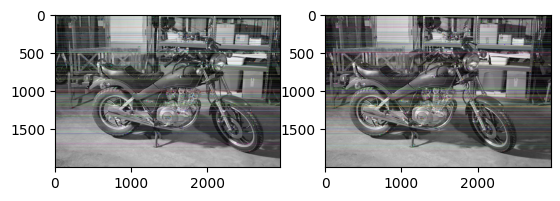

In [ ]:
#@title Linea epipolar
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
import os

class EpipolarGeometry:
    def __init__(self,showImages):
        # Load Images
        root = '/content/drive/MyDrive/Pregrado-UIS/SEMESTRE-IX-2024-1/Hands-on/Notebook/images/motorcycle'
        imgLeftPath = os.path.join(root, 'imL.png')
        imgRightPath = os.path.join(root, 'imR.png')
        self.imgLeft = cv.imread(imgLeftPath, cv.IMREAD_GRAYSCALE)
        self.imgRight = cv.imread(imgRightPath, cv.IMREAD_GRAYSCALE)

        if showImages:
            plt.figure()
            plt.subplot(121)
            plt.imshow(self.imgLeft)
            plt.subplot(122)
            plt.imshow(self.imgRight)
            plt.show()

    def drawStereoEpilines(self):
        # Feature Matching
        sift = cv.SIFT_create()
        kpLeft,desLeft = sift.detectAndCompute(self.imgLeft,None)
        kpRight,desRight = sift.detectAndCompute(self.imgRight,None)
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        flann = cv.FlannBasedMatcher(index_params,search_params)
        matches = flann.knnMatch(desLeft,desRight,k=2)
        ptsLeft = []
        ptsRight = []
        for i,(m,n) in enumerate(matches):
            if m.distance < 0.8*n.distance:
                ptsRight.append(kpRight[m.trainIdx].pt)
                ptsLeft.append(kpLeft[m.queryIdx].pt)

        # Calc fundamental matrix
        ptsLeft = np.int32(ptsLeft)
        ptsRight = np.int32(ptsRight)
        F,mask = cv.findFundamentalMat(ptsLeft,ptsRight,cv.FM_LMEDS)

        # Extract points
        ptsLeft = ptsLeft[mask.ravel()==1]
        ptsRight = ptsRight[mask.ravel()==1]
        step = 10
        ptsLeft = ptsLeft[::step,:]
        ptsRight = ptsRight[::step,:]

        # Draw epilines on left and right images
        linesLeft = cv.computeCorrespondEpilines(ptsRight.reshape(-1,1,2),2,F)
        linesLeft = linesLeft.reshape(-1,3)
        imgLeftLines,_ = EpipolarGeometry.drawLines(self.imgLeft,self.imgRight,linesLeft,ptsLeft,ptsRight)
        linesRight = cv.computeCorrespondEpilines(ptsLeft.reshape(-1,1,2),1,F)
        linesRight = linesRight.reshape(-1,3)
        imgRightLines,_ = EpipolarGeometry.drawLines(self.imgRight,self.imgLeft,linesRight,ptsRight,ptsLeft)
        plt.subplot(121)
        plt.imshow(imgLeftLines)
        plt.subplot(122)
        plt.imshow(imgRightLines)
        plt.show()

    @staticmethod
    def drawLines(imgLeft,imgRight,lines,ptsLeft,ptsRight):
        r,c = imgLeft.shape
        imgLeft = cv.cvtColor(imgLeft,cv.COLOR_GRAY2BGR)
        imgRight = cv.cvtColor(imgRight,cv.COLOR_GRAY2BGR)
        for r,pt1,pt2 in zip(lines,ptsLeft,ptsRight):
            color = tuple(np.random.randint(0,255,3).tolist())
            x0,y0 = map(int,[0,-r[2]/r[1]])
            x1,y1 = map(int,[c,-(r[2]+r[0]*c)/r[1]])
            imgLeft = cv.line(imgLeft,(x0,y0),(x1,y1),color,1)
            imgLeft = cv.circle(imgLeft,tuple(pt1),5,color,-1)
            imgRight = cv.circle(imgRight,tuple(pt2),5,color,-1)
        return imgLeft,imgRight

def demoViewPics():
    # See pictures
    eg = EpipolarGeometry(showImages=True)

def demoDrawEpilines():
    # Draw epilines
    eg = EpipolarGeometry(showImages=False)
    eg.drawStereoEpilines()

if __name__ == '__main__':
    # demoViewPics()
    demoDrawEpilines()